![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
from datetime import datetime
import re

In [ ]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [ ]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [ ]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [ ]:
df_train.info()

In [ ]:
df_train.head(5)

In [ ]:
df_test.info()

In [ ]:
df_test.head(5)

In [ ]:
sample_submission.head(5)

In [ ]:
sample_submission.info()

In [ ]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [ ]:
data.info()

Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [ ]:
data.sample(5)

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

 # Restaurant_id

Посмотрим на параметр "Restaurant_id". Данные представляют собой строковые значения, пропусков нет. Проверим, все ли значения уникальны.

In [ ]:
data['Restaurant_id'].nunique(dropna=False)

In [ ]:
data['Restaurant_id'].value_counts()

In [ ]:
data.groupby('Restaurant_id')['Rating'].agg('mean')

Создадим новый признак, в который передадим Restaurant_id в числовом формате. Одновременно создадим список, в который будем сохранять признаки, которые не понадобятся на этапе ML.


In [ ]:
drop_list = list()

In [ ]:
data['Restaurant_id_num'] = data['Restaurant_id'].apply(lambda x: int(x[3::]))
drop_list.append('Restaurant_id')

In [ ]:
data[['Restaurant_id_num', 'Rating']].corr()

Как видно из корреляционного анализа, есть заметная обратная зависимость рейтинга от id ресторана.

# City

In [ ]:
data['City'].nunique(dropna=False)

В этом столбце также нет пропусков, и всего 31 уникальное значение. Эти данные можно будет использовать для создание дополнительных признаков. Для начала создадим dummy-переменные. Чтобы не потерять оригинальный столбец, который планируется использовать для генерации других признаков, dummy-переменные создаем на основании дублираованного столбца.

In [ ]:
data['City_code'] = data['City']
data = pd.get_dummies(data, columns=[ 'City_code',], dummy_na=True)

Среди городов есть столицы. Создадим столбец, указывающий на этот признак.

In [ ]:
capitals = ['Athens', 'Berlin', 'Bratislava', 'Brussels', 'Budapest', 'Copenhagen', 'Dublin', 'Helsinki',
            'Lisbon', 'Ljubljana', 'London', 'Luxembourg', 'Madrid', 'Oslo', 'Paris', 'Rome', 'Stockholm',
            'Vienna', 'Warsaw','Zurich']    
data['is_capital'] = data['City'].apply(lambda x: 1 if x in capitals else 0)

In [ ]:
data['is_capital'].value_counts()

Также встречаются города из одной страны. Создадим новый признак "Country" и сгенерируем на его основе dummy-переменные. Этот признак создадим только для тех стран, которые представлены несколькими странами, так как в противном случае этот признак будет дублирующим для определенных городов.

In [ ]:
def country(row):
    if row['City'] in ['Berlin', 'Hamburg', 'Munich']:
        return 'Germany'
    elif row['City'] in ['Geneva', 'Zurich']:
        return 'Switzerland' 
    elif row['City'] in ['Krakow', 'Prague', 'Warsaw']:
        return 'Poland'
    elif row['City'] in ['Lisbon', 'Oporto']:
        return 'Portugal'
    elif row['City'] in ['Lyon', 'Paris']:
        return 'France'
    elif row['City'] in ['Milan', 'Rome']:
        return 'Italy'
    else:
        return None
    
data['Country'] = data.apply(country, axis=1)
data = pd.get_dummies(data, columns=['Country'], dummy_na=True)
data.drop(['Country_nan'], axis=1, inplace=True)

Также можно добавить признак с населением грода. Для этого загрузим дополнительные данные.

In [ ]:
city_pop = pd.read_excel('../input/european-city-population-and-area/PopulatinandArea.xlsx')

In [ ]:
city_pop.head()

In [ ]:
city_pop.info()

In [ ]:
def population(row):
    return int(city_pop[city_pop['City'] == row['City']]['Population'])

data['Population'] = data.apply(population, axis=1)

In [ ]:
# Хотя при создании этого столбца не возникло ошибок, убедимся на всякий случай, что население для каждого города было успешно найдено.
data['Population'].isna().sum()

In [ ]:
data[['Rating', 'Population']].corr()

Так же в датасете есть данные о площоди города. Добавим признак 'Population_density'.

In [ ]:
city_pop.columns.to_list()

In [ ]:
def pop_density(row):
    pop = row['Population']
    area = city_pop[city_pop['City'] == row['City']]['Area in km2 '].values[0]
    return pop/area

data['Population_density'] = data.apply(pop_density, axis=1)

In [ ]:
data['Population_density']

In [ ]:
data[['Rating', 'Population', 'Population_density']].corr()

Также, используя таблицу city_pop, удобно создать столбец с странами для каждого города.

In [ ]:
def country(row):
    return city_pop[city_pop['City'] == row['City']]['Country'].values[0]

data['Country'] = data.apply(country, axis=1)


In [ ]:
drop_list.append('Country')

Используя другой датасет, сгенерируем новые признаки 'Happiness' и 'GDP_perCapita', исходя из стран. В результате предварительного анализа, выяснилось, что 'Beer_perCapita', 'Spirit_perCapita', 'Wine_perCapita' дублируют 'GDP_perCapita', поэтому их не испоьзовали.

In [ ]:
Happiness_alcohol = pd.read_csv('../input/happiness-and-alcohol-consumption/HappinessAlcoholConsumption.csv')
Happiness_alcohol.head()

In [ ]:
Happiness_alcohol.info()

In [ ]:
Happiness_alcohol['Country'].to_list()

In [ ]:
# В датасете не совпадали названия нескольких стран, а именно для Чехии и Нидерландов, также не было данных для Англии и Шотландии по отдельности. 
# Это пришлось учесть при написании функции.
def happiness(row):
    if row['Country'] in ['England', 'Scotland']:
        return Happiness_alcohol[Happiness_alcohol['Country'] == 'United Kingdom']['HappinessScore'].values[0]
    if row['Country'] == 'Netherland':
        return Happiness_alcohol[Happiness_alcohol['Country'] == 'Netherlands']['HappinessScore'].values[0]
    if row['Country'] == 'Czech':
        return Happiness_alcohol[Happiness_alcohol['Country'] == 'Czech Republic']['HappinessScore'].values[0]
    return Happiness_alcohol[Happiness_alcohol['Country'] == row['Country']]['HappinessScore'].values[0]

data['Happiness'] = data.apply(happiness, axis=1)

In [ ]:
def GDP(row):
    if row['Country'] in ['England', 'Scotland']:
        return Happiness_alcohol[Happiness_alcohol['Country'] == 'United Kingdom']['GDP_PerCapita'].values[0]
    if row['Country'] == 'Netherland':
        return Happiness_alcohol[Happiness_alcohol['Country'] == 'Netherlands']['GDP_PerCapita'].values[0]
    if row['Country'] == 'Czech':
        return Happiness_alcohol[Happiness_alcohol['Country'] == 'Czech Republic']['GDP_PerCapita'].values[0]
    return Happiness_alcohol[Happiness_alcohol['Country'] == row['Country']]['GDP_PerCapita'].values[0]

data['GDP_PerCapita'] = data.apply(GDP, axis=1)

In [ ]:
import math

In [ ]:
drop_list.append('City')
drop_list.append('City_code_nan')

# Cuisine Style

In [ ]:
data['Cuisine Style'].isna().sum()

Обработаем данные из столбца "Cuisine Style".
Данные представляют собой строковые значения, которые выглядят как список из нескольких видов кухни, а также содержат пустые значения.
Обработаем признак с помощью метода One-Hot encoding, а также создадим список всех видов кухни, который будем использовать для кодировки. 

Кроме того, создадим еще признак о количестве видов кухни.

In [ ]:
Cuisine_list = set()

for styles in data['Cuisine Style']:
    if pd.isna(styles):
        continue    
    else:
        styles = styles[1:-1].split(', ')
        for style in styles:
            Cuisine_list.add(style[1:-1])

# Здесь невозможно использовать функцию get_dummies, так как необходимо выделять виды кухни из строкового значения            
def find_item(cell):
    if item in str(cell):
        return 1
    else:
        return 0

for style in Cuisine_list:
    item = style
    name = 'Cuisine_{}'.format(item)
    data[name] = data['Cuisine Style'].apply(find_item)
    

# Tак как здесь не использовалать функция get_dummies, необходимо дополнительно прописать функцию, для создания dummy-переменной в случае значения None
def fill_cuisine_nan(row):
    if pd.isna(row['Cuisine Style']):
        return 1
    else:
        return 0
    
data['Cuisine_nan'] = data.apply(fill_cuisine_nan, axis=1)

In [ ]:
Cuisine_list

In [ ]:
def variety(row):
    if pd.isna(row['Cuisine Style']):
        return 0    
    return len(row['Cuisine Style'].split(', '))
        
data['Cuisine_variety'] = data.apply(variety, axis=1)

Сгенерируем признак, в который запишем инфомацию, подается ли в ресторане национальная кухня.

In [ ]:
National_cuisine = {'France': 'French', 'England': 'British', 'Spain': 'Spanish', 'Italy': 'Italian', 'Germany': 'German', 'Portugal': 'Portuguese',
                    'Czech': 'Czech', 'Poland': 'Polish', 'Austria': 'Austrian', 'Netherland': 'Dutch', 'Belgium': 'Belgian', 'Switzerland': 'Swiss', 
                    'Sweden': 'Swedish', 'Hungary': 'Hungarian', 'Ireland': 'Irish', 'Denmark': 'Danish', 'Greece': 'Greek', 'Scotland': 'Scottish',
                    'Norway': 'Norwegian', 'Finland': 'Finnish', 'Slovakia': 'Slovak', 'Luxembourg': 'Luximbourgish', 'Slovenia': 'Slovenian'}


In [ ]:
National_cuisine = {'France': 'French', 'England': 'British', 'Spain': 'Spanish', 'Italy': 'Italian', 'Germany': 'German', 'Portugal': 'Portuguese',
                    'Czech': 'Czech', 'Poland': 'Polish', 'Austria': 'Austrian', 'Netherland': 'Dutch', 'Belgium': 'Belgian', 'Switzerland': 'Swiss', 
                    'Sweden': 'Swedish', 'Hungary': 'Hungarian', 'Ireland': 'Irish', 'Denmark': 'Danish', 'Greece': 'Greek', 'Scotland': 'Scottish',
                    'Norway': 'Norwegian', 'Finland': 'Finnish', 'Slovakia': 'Slovak', 'Luxembourg': 'Luximbourgish', 'Slovenia': 'Slovenian'}

def national_cuisine(row):
    if pd.isna(row["Cuisine Style"]):
        return 0
    for value, key in National_cuisine.items():
        if value == row['Country']:
            if key in row['Cuisine Style']:
                return 1
    return 0
data['National_cuisine'] = data.apply(national_cuisine, axis=1)

In [ ]:
data['National_cuisine'].value_counts()

In [ ]:
data[['Rating', 'National_cuisine']].corr()

In [ ]:
drop_list.append('Cuisine Style')

# Ranking

В этом столбце нет пропусков. Посмотрим как изменяется Ranking по городам, а также проверим, есть ли связь между Ranking и id ресторана.

In [ ]:
# Построим график для десяти городов с найбольшим количеством ресторанов
for x in (data['City'].value_counts())[0:10].index:
    data['Ranking'][data['City'] == x].hist(bins=100)
plt.show()

Из-за того, что количество ресторанов в городах разное, масимальное значение Ranking для рестоанов будет разным в разных городах. Необходимо отнормировать этот признак, относитльно города.

In [ ]:
ranking_mean = data.groupby('City')['Ranking'].agg('mean')
rest_num = data['City'].value_counts()

In [ ]:
def norm(row):
    return (row['Ranking']-ranking_mean[row['City']])/rest_num[row['City']]

data['Ranking_norm'] = data.apply(norm, axis=1)

In [ ]:
# Построим на график после нормирования
for x in (data['City'].value_counts())[0:10].index:
    data['Ranking_norm'][data['City'] == x].hist(bins=100)
plt.show()

In [ ]:
for x in (data['City'].value_counts())[0:10].index:
    data['Restaurant_id_num'][data['City'] == x].hist(bins=100)
plt.show()

Распределение 'Restaurant_id' тожу чувствительно к количеству ресторанов в городе. Нормируем и это значение.

In [ ]:
id_mean = data.groupby('City')['Restaurant_id_num'].agg('mean')

def id_norm(row):
    return (row['Restaurant_id_num']-id_mean[row['City']])/rest_num[row['City']]

data['Restaurant_id_norm'] = data.apply(id_norm, axis=1)

In [ ]:
for x in (data['City'].value_counts())[0:10].index:
    data['Restaurant_id_norm'][data['City'] == x].hist(bins=100)
plt.show()

In [ ]:
data[['Ranking', 'Ranking_norm', 'Restaurant_id_num', 'Restaurant_id_norm', 'Rating']].corr()

Так, с помощью нормирования удалось усилить корреляцию значений Ranking и Restaurant_id с рейтингом.

In [ ]:
drop_list.append('Ranking')
drop_list.append('Restaurant_id_num')

# Price Range

In [ ]:
data['Price Range'].value_counts()

In [ ]:
data['Price Range'].isna().sum()

В данном столбце много пропусков (~35%). Трансформируем значения в числа для упрощения работы.

In [ ]:
# 3:$$$$
# 2:$$ - $$$
# 1: $
# 0: NaN
def fill_price_r(row):
    if row['Price Range'] == '$$$$':
        return 3
    if row['Price Range'] == '$$ - $$$':
        return 2
    if row['Price Range'] == '$':
        return 1
    return None
    
data['Price Range'] = data.apply(fill_price_r, axis=1)

In [ ]:
data['Price Range'].median()

Заполним пропуски медианным значением. Но перед этим сохраним информацию о пропусках в отдельном столбце.

In [ ]:
data['no_price_data'] = data['Price Range'].apply(lambda x: 1 if pd.isna(x) else 0)

In [ ]:
data['no_price_data'].value_counts()

In [ ]:
data['Price Range'].fillna(data['Price Range'].median(), inplace=True)

In [ ]:
data['Price Range'].hist(bins=3)

# Number of Reviews

In [ ]:
data['Number of Reviews'].isna().sum()

Здесь также присутствуют пропуски. Прежде, чем их заменить, также сохраним информацию о них в отдельном столбце.

In [ ]:
data['no_data_Number_of_Reviews'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [ ]:
data['no_data_Number_of_Reviews'].value_counts()

Посмотрим, как распределен признак.

In [ ]:
data['Number of Reviews'].hist(bins=100)

Видно, что в большинстве случаев количество отзывов не превышает 100. Посмотрим на гистограмму в этом диапазоне.

In [ ]:
data[data['Number of Reviews']<100]['Number of Reviews'].hist()

In [ ]:
def fill_num_rev(row):
    if pd.isna(row['Number of Reviews']):
        return data[data['City'] == row['City']]['Number of Reviews'].median()
    return row['Number of Reviews']
    
data['Number of Reviews_filled'] = data.apply(fill_num_rev, axis=1)

In [ ]:
data[['Number of Reviews', 'Number of Reviews_filled', 'Population', 'Ranking_norm', 'Population_density']].corr()

In [ ]:
data[['Number of Reviews', 'Number of Reviews_filled', 'Rating']].corr()

In [ ]:
data.groupby('City')['Number of Reviews'].agg(['mean', 'median'])

In [ ]:
data[data['Number of Reviews']<100]['Number of Reviews'].hist()

Заполнить пропуски каким-то конкретным значением на мой взгляд не будет корректным. Сгенерируем новый признак, который характеризовал бы середину диапазона, в который попадает то или иное значение количества отзывов. Для этого каждое значение разделим на 50 и округлим до целого.

In [ ]:
data['Number of Reviews_50'] = data['Number of Reviews'].apply(lambda x: None if pd.isna(x) else round(x/50, 0))

In [ ]:
data['Number of Reviews_50'].hist(bins=100)

Проверим, сможем ли мы заполнять пропуски медианным значением в зависимости от города.

In [ ]:
data.groupby('City')['Number of Reviews_50'].agg(['mean', 'median'])

In [ ]:
def fill_num_rev(row):
    if pd.isna(row['Number of Reviews_50']):
        return data[data['City'] == row['City']]['Number of Reviews_50'].min()
    return row['Number of Reviews_50']

data['Number of Reviews_50_min'] = data.apply(fill_num_rev, axis=1)

In [ ]:
data['Number of Reviews_50_min'].value_counts()

In [ ]:
data[data['Number of Reviews_50_min'] < 5]['Number of Reviews_50_min'].hist(bins=4)

Проверим, не потеряли ли мы коррелецию в результате проведенных манипуляций.

In [ ]:
data[['Number of Reviews', 'Number of Reviews_50','Number of Reviews_50_min', 'Rating']].corr()

In [ ]:
drop_list.append('Number of Reviews')
drop_list.append('Number of Reviews_50')

# Reviews

In [ ]:
data['Reviews'].isna().sum()

На первый взглд здесь всего лишь 2 пропуска, но если просмотреть значения, то можно заметить довольно много значений вида '[[],[]]', что также можно рассматривать как пустые значения. В среднем структура значений представляеи собой список из двух вложенных списков: текст отзыва и дата отзыва. Проверим, сколько отзывов модет быть вложено.

In [ ]:
data['Reviews_num'] = data['Reviews'].apply(lambda x: 0 if str(x) == '[[], []]' else len(str(x).split('], [')[0].split("', '")))
data['Reviews_num'].fillna(0, inplace=True)
data['Reviews_num'].value_counts()

Далее извлечем даты в отдельные столбцы, а также посчитаем время между двумя отзывами и как давно был сделан последний отзыв.

In [ ]:
def find_date(string):
    pattern = re.compile('\d\d\/\d\d\/\d\d\d\d')
    return pattern.findall(string)


def date_1(row):
    if pd.isna(row['Reviews']):
        return None
    date_list = find_date(row['Reviews'])
    if len(date_list) == 0:
        return None
    else:
        date_1 = datetime.strptime(date_list[0], '%m/%d/%Y')
        if len(date_list) > 1:
            date_2 = datetime.strptime(date_list[1], '%m/%d/%Y')
            if date_1 > date_2:
                return date_1
            else:
                return date_2
        return date_1


def date_2(row):
    if pd.isna(row['Reviews']):
        return None
    date_list = find_date(row['Reviews'])
    if len(date_list) in [0, 1]:
        return None
    else:
        date_1 = datetime.strptime(date_list[0], '%m/%d/%Y')
        date_2 = datetime.strptime(date_list[1], '%m/%d/%Y')
        if date_1 > date_2:
            return date_2
        else:
            return date_1


data['last_date_1'] = data.apply(date_1, axis=1)
data['last_date_2'] = data.apply(date_2, axis=1)

In [ ]:
# Новые столбец с количеством дней между отзывами
def days_btw(row):
    if pd.isna(row['last_date_2']):
        return None
    return (row['last_date_1']-row['last_date_2']).days


data['days_btw_rev'] = data.apply(days_btw, axis=1)

In [ ]:
data['days_btw_rev'].isna().sum()

Тут получилось довольно много пропусков. Посмотрим на распределение признака.

In [ ]:
data['days_btw_rev'].hist(bins=100)

Здесь можно наблюдать аналогичную ситуацию, как в случае с количеством отзывов ('Number of Reviews'). Для заполнения пропусков поступим также.

In [ ]:
data[data['days_btw_rev']<400]['days_btw_rev'].hist(bins=5)

In [ ]:
def fill_days_btw(row):
    if pd.isna(row['days_btw_rev']):
        return data[data['City'] == row['City']]['days_btw_rev'].median()
    return row['days_btw_rev']
data['days_btw_rev_filled'] = data.apply(fill_days_btw, axis=1)

In [ ]:
data['days_btw_rev_filled'].isna().sum()

In [ ]:
# Новый признак, характеризующий диапазон, в который попадает значение 'days_btw_rev'
data['days_btw_rev_100'] = data['days_btw_rev'].apply(lambda x: None if x is None else round(x/100, 0))

In [ ]:
# Проверяем, есть ли зависимость от города
data.groupby('City')['days_btw_rev_100'].agg(['mean', 'median'])

In [ ]:
# Функция для заполнения пропусков
def fill_days_btw(row):
    if pd.isna(row['days_btw_rev_100']):
        return data[data['City'] == row['City']]['days_btw_rev_100'].median()
    return row['days_btw_rev_100']

data['days_btw_rev_100'] = data.apply(fill_days_btw, axis=1)

In [ ]:
data[['Rating', 'days_btw_rev_filled', 'days_btw_rev_100']].corr()

In [ ]:
data[data['days_btw_rev_100'] < 5]['days_btw_rev_100'].hist(bins=5)

In [ ]:
# Новый признак, характеризующий, как давно был оставлен последний отзыв. В качестве референса возьмем максимальное значение из всех
def days_since(row):
    if pd.isna(row['last_date_1']):
        return None
    else:
        return (data['last_date_1'].max()-row['last_date_1']).days


data['days_since_last_rev'] = data.apply(days_since, axis=1)

In [ ]:
# Пропуски
data['days_since_last_rev'].isna().sum()

In [ ]:
# Посмотрим на распределение признака
data['days_since_last_rev'].hist(bins=100)

In [ ]:
data[data['days_since_last_rev']<500]['days_since_last_rev'].hist(bins=100)

In [ ]:
def fill_days_since(row):
    if pd.isna(row['days_since_last_rev']):
        return data[data['City'] == row['City']]['days_since_last_rev'].median()
    return row['days_since_last_rev']
data['days_since_last_rev_filled'] = data.apply(fill_days_since, axis=1)

In [ ]:
# Новый признак, характеризующий диапазон, в который попадает значение 'days_since_last_rev'
data['days_since_last_rev_100'] = data['days_since_last_rev'].apply(lambda x: None if x is None else round(x/100, 0))

In [ ]:
# По гистограмме видно, что вид распределения сохраняется после преобразования
data[data['days_since_last_rev_100']<5]['days_since_last_rev_100'].hist(bins=5)

In [ ]:
# Функция для заполнения пропусков
def fill_days_since(row):
    if pd.isna(row['days_since_last_rev_100']):
        return data[data['City'] == row['City']]['days_since_last_rev_100'].median()
    return row['days_since_last_rev_100']

data['days_since_last_rev_100'] = data.apply(fill_days_since, axis=1)

In [ ]:
data[data['days_since_last_rev_100']<5]['days_since_last_rev_100'].hist(bins=5)

In [ ]:
data[['Rating', 'days_since_last_rev_filled', 'days_since_last_rev_100']].corr()

Попробуем определить положительный или негативный характер отзыва по ключевым словам

In [ ]:
positive_list = ['good', 'lovely', 'great', 'perfect', 'awesome', 'best', 'excellent', 'pleasent',
                'outstanding', 'exceptional', 'fantastic', 'wonderful', 'fabulous', 'worth'
                'enjoyable', 'nice', 'cosy', 'tasty', 'delicious', 'friendly', 'decent', 'gem',
                'happy']


negative_list = ['bad', 'terrible', 'awful', 'poor', 'unacceptable', 'worst', 'gross',
                 'regret', 'unpleasent', 'unsatisfactory', 'disgusting', 'unfriendly',
                'rude', 'overpriced', 'slow', 'dissapoint', 'inadequate', 'weak', 'worse'
                'unhappy', 'unfortunate']


In [ ]:
def positive_rev(row):
    a = str(row['Reviews']).lower().split('], [')[0].split("', '")
    for word in positive_list:
        if len(a) == 2:
            if ((word in a[0]) and not ('not' in a[0])) and (
                (word in a[1]) and not ('not' in a[1])):
                return 5
            elif ((word in a[0]) and not ('not' in a[0])) or (
                (word in a[1]) and not ('not' in a[1])):
                return 4
        elif len(a) == 1:
            if ((word in a[0]) and not ('not' in a[0])):
                return 4
    for word in negative_list:
        if len(a) == 2:
            if ((word in a[0]) and not ('not' in a[0])) and (
                (word in a[1]) and not ('not' in a[1])):
                return 1
            elif ((word in a[0]) and not ('not' in a[0])) or (
                (word in a[1]) and not ('not' in a[1])):
                return 2
        elif len(a) == 1:
            if ((word in a[0]) and not ('not' in a[0])):
                return 2
    return 3

data['Positive_rev'] = data.apply(positive_rev, axis=1)

In [ ]:
data['Positive_rev'].value_counts()

In [ ]:
data[['Rating', 'Positive_rev']].corr()

In [ ]:
drop_list.append('Reviews')
drop_list.append('last_date_1')
drop_list.append('last_date_2')
drop_list.append('days_btw_rev')
drop_list.append('days_since_last_rev')

# ID_TA

In [ ]:
data['ID_TA'].isna().sum()

In [ ]:
data['ID_TA']

В данном столбце пропусков нет. Можно заметить,что каждое значение выглядит как числовой код с буквой 'd' в начале. Создадим новый признак, куда передадим эти данные в числовом формате.

In [ ]:
data['ID_TA_num'] = data['ID_TA'].apply(lambda x: int(x[1::]))

In [ ]:
data[['ID_TA_num', 'Rating']].corr()

# URL_TA

In [284]:
data['URL_TA'].isna().sum()

0

In [285]:
data.loc[0,'URL_TA']

'/Restaurant_Review-g187147-d10746918-Reviews-Le_Perchoir-Paris_Ile_de_France.html'

Значения в этом случае имеют несколько числовых последовательностей, начинающихся с 'g' и 'd'. Вторая последовательность дублирует значения в ID_TA. Поэтому выделим в отдельный признак только первую последовательность.

In [286]:
data['URL_TA_num'] = data['URL_TA'].apply(lambda x: int(x.split('-')[1][1::]))

In [287]:
data[['URL_TA_num', 'Rating']].corr()

,URL_TA_num,Rating
URL_TA_num,1.000000,0.003463
Rating,0.003463,1.000000


In [288]:
drop_list.append('URL_TA')

# Посмотрим распределение целевой переменной 'Rating'

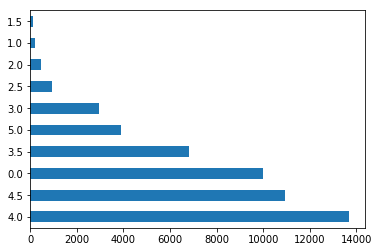

In [289]:
data['Rating'].value_counts().plot(kind='barh')

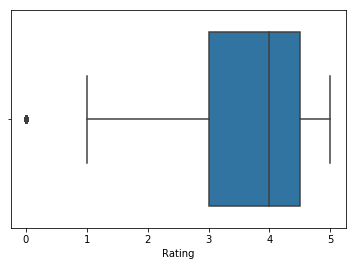

In [290]:
sns.boxplot(x='Rating', data=data)

In [291]:
drop_list.append('Rating')

In [292]:
drop_list

['Restaurant_id',
 'Country',
 'City',
 'City_code_nan',
 'Cuisine Style',
 'Ranking',
 'Restaurant_id_num',
 'Number of Reviews',
 'Number of Reviews_50',
 'Reviews',
 'last_date_1',
 'last_date_2',
 'days_btw_rev',
 'days_since_last_rev',
 'URL_TA',
 'Rating']

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

In [293]:
data[['Ranking', 'Restaurant_id_num']].corr()

,Ranking,Restaurant_id_num
Ranking,1.00000,0.82509
Restaurant_id_num,0.82509,1.00000


In [294]:
data.groupby('City')['Rating'].agg(['min', 'max', 'mean', 'median'])

,min,max,mean,median
City,,,,
Amsterdam,0.0,5.0,3.270044,4.0
Athens,0.0,5.0,3.423325,4.0
Barcelona,0.0,5.0,3.189985,4.0
Berlin,0.0,5.0,3.285952,4.0
Bratislava,0.0,5.0,3.144737,4.0
Brussels,0.0,5.0,3.153349,4.0
Budapest,0.0,5.0,3.268854,4.0
Copenhagen,0.0,5.0,3.206960,4.0
Dublin,0.0,5.0,3.269737,4.0


In [295]:
data['Rating'].isna().sum()

0

In [296]:
city_rating_mean = data.groupby('City')['Rating'].agg('mean')
city_rating_mean['Berlin']

3.285951940850277

In [297]:
data['City'].value_counts()['Berlin']

2705

In [298]:

def city_rating_mean_norm(row):
    return (row['Rating']-city_rating_mean[row['City']])/data['City'].value_counts()[row['City']]
    
data['city_rating_mean_norm'] = data.apply(city_rating_mean_norm, axis=1)


In [299]:
data[['Rating', 'city_rating_mean_norm']].corr()

,Rating,city_rating_mean_norm
Rating,1.000000,0.719317
city_rating_mean_norm,0.719317,1.000000


In [300]:
data['city_rating_mean_norm']

0       -0.000517
1       -0.006577
2       -0.004390
3       -0.000440
4       -0.008276
           ...   
49995    0.000546
49996    0.000056
49997    0.001382
49998    0.000850
49999   -0.000011
Name: city_rating_mean_norm, Length: 50000, dtype: float64

In [301]:
city_rating_mean = data.groupby('City')['Rating'].agg('mean')
def city_rev_num_mean_norm(row):
    return (row['Number of Reviews_filled']-city_rating_mean[row['City']])/data['City'].value_counts()[row['City']]
    
data['city_rev_num_mean_norm'] = data.apply(city_rev_num_mean_norm, axis=1)

In [302]:
data[['Rating', 'city_rev_num_mean_norm', 'Number of Reviews_filled']].corr()

,Rating,city_rev_num_mean_norm,Number of Reviews_filled
Rating,1.000000,0.007845,0.011235
city_rev_num_mean_norm,0.007845,1.000000,0.716167
Number of Reviews_filled,0.011235,0.716167,1.000000


# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [303]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Перебором была определена комбинация тех признаков, которая показывала наилучший результат. Следовательно генерация только этих признаков была включена в следующую функцию.

In [304]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    
    df_output = df_input.copy()
    
    df_output['Number of Reviews_filled_0'] = df_output['Number of Reviews'].fillna(0)
    
    df_output['Restaurant_id_num'] = df_output['Restaurant_id'].apply(lambda x: int(x[3::]))
    print('Restaurant_id')
    df_output['City_code'] = df_output['City']
    df_output = pd.get_dummies(df_output, columns=[ 'City_code',], dummy_na=True)
    
    capitals = ['Athens', 'Berlin', 'Bratislava', 'Brussels', 'Budapest', 'Copenhagen', 'Dublin', 'Helsinki',
            'Lisbon', 'Ljubljana', 'London', 'Luxembourg', 'Madrid', 'Oslo', 'Paris', 'Rome', 'Stockholm',
            'Vienna', 'Warsaw','Zurich']    
    df_output['is_capital'] =  df_output['City'].apply(lambda x: 1 if x in capitals else 0)
    
    def country(row):
        if row['City'] in ['Berlin', 'Hamburg', 'Munich']:
            return 'Germany'
        elif row['City'] in ['Geneva', 'Zurich']:
            return 'Switzerland' 
        elif row['City'] in ['Krakow', 'Prague', 'Warsaw']:
            return 'Poland'
        elif row['City'] in ['Lisbon', 'Oporto']:
            return 'Portugal'
        elif row['City'] in ['Lyon', 'Paris']:
            return 'France'
        elif row['City'] in ['Milan', 'Rome']:
            return 'Italy'
        else:
            return None

    df_output['Country'] = df_output.apply(country, axis=1)
    df_output = pd.get_dummies(df_output, columns=['Country'], dummy_na=True)
    df_output.drop(['Country_nan'], axis=1, inplace=True)
    
    def country(row):
        return city_pop[city_pop['City'] == row['City']]['Country'].values[0]

    df_output['Country'] = df_output.apply(country, axis=1)
    
    Happiness_alcohol = pd.read_csv('../input/happiness-and-alcohol-consumption/HappinessAlcoholConsumption.csv')

    def happiness(row):
        if row['Country'] in ['England', 'Scotland']:
            return Happiness_alcohol[Happiness_alcohol['Country'] == 'United Kingdom']['HappinessScore'].values[0]
        if row['Country'] == 'Netherland':
            return Happiness_alcohol[Happiness_alcohol['Country'] == 'Netherlands']['HappinessScore'].values[0]
        if row['Country'] == 'Czech':
            return Happiness_alcohol[Happiness_alcohol['Country'] == 'Czech Republic']['HappinessScore'].values[0]
        return Happiness_alcohol[Happiness_alcohol['Country'] == row['Country']]['HappinessScore'].values[0]

    df_output['Happiness'] = df_output.apply(happiness, axis=1)
    
    def GDP(row):
        if row['Country'] in ['England', 'Scotland']:
            return Happiness_alcohol[Happiness_alcohol['Country'] == 'United Kingdom']['GDP_PerCapita'].values[0]
        if row['Country'] == 'Netherland':
            return Happiness_alcohol[Happiness_alcohol['Country'] == 'Netherlands']['GDP_PerCapita'].values[0]
        if row['Country'] == 'Czech':
            return Happiness_alcohol[Happiness_alcohol['Country'] == 'Czech Republic']['GDP_PerCapita'].values[0]
        return Happiness_alcohol[Happiness_alcohol['Country'] == row['Country']]['GDP_PerCapita'].values[0]

    df_output['GDP_PerCapita'] = df_output.apply(GDP, axis=1)
    
    print('City')
    
    Cuisine_list = set()

    for styles in df_output['Cuisine Style']:
        if pd.isna(styles):
            continue    
        else:
            styles = styles[1:-1].split(', ')
            for style in styles:
                Cuisine_list.add(style[1:-1])

    def find_item(cell):
        if item in str(cell):
            return 1
        else:
            return 0

    for style in Cuisine_list:
        item = style
        name = 'Cuisine_{}'.format(item)
        df_output[name] =df_output['Cuisine Style'].apply(find_item)

    def fill_cuisine_nan(row):
        if pd.isna(row['Cuisine Style']):
            return 1
        else:
            return 0
    
    df_output['Cuisine_nan'] = df_output.apply(fill_cuisine_nan, axis=1)
    
    def variety(row):
        if pd.isna(row['Cuisine Style']):
            return 0    
        return len(row['Cuisine Style'].split(', '))

    df_output['Cuisine_variety'] = df_output.apply(variety, axis=1)
    
    National_cuisine = {'France': 'French', 'England': 'British', 'Spain': 'Spanish', 'Italy': 'Italian', 'Germany': 'German', 'Portugal': 'Portuguese',
                    'Czech': 'Czech', 'Poland': 'Polish', 'Austria': 'Austrian', 'Netherland': 'Dutch', 'Belgium': 'Belgian', 'Switzerland': 'Swiss', 
                    'Sweden': 'Swedish', 'Hungary': 'Hungarian', 'Ireland': 'Irish', 'Denmark': 'Danish', 'Greece': 'Greek', 'Scotland': 'Scottish',
                    'Norway': 'Norwegian', 'Finland': 'Finnish', 'Slovakia': 'Slovak', 'Luxembourg': 'Luximbourgish', 'Slovenia': 'Slovenian'}

    def national_cuisine(row):
        if pd.isna(row["Cuisine Style"]):
            return 0
        for value, key in National_cuisine.items():
            if value == row['Country']:
                if key in row['Cuisine Style']:
                    return 1
        return 0
    
    df_output['National_cuisine'] = df_output.apply(national_cuisine, axis=1)
    
    print('Cuisine')
    
    ranking_mean = df_output.groupby('City')['Ranking'].agg('mean')
    rest_num = df_output['City'].value_counts()
    
    def norm(row):
        return (row['Ranking']-ranking_mean[row['City']])/rest_num[row['City']]

    df_output['Ranking_norm'] = df_output.apply(norm, axis=1)
    
    print('Ranking')
    
    df_output['no_price_data'] =  df_output['Price Range'].apply(lambda x: 1 if x is None else 0)
    
    def fill_price_r(row):
        if row['Price Range'] == '$$$$':
            return 3
        if row['Price Range'] == '$$ - $$$':
            return 2
        if row['Price Range'] == '$':
            return 1
        return 2
    
    df_output['Price Range'] = df_output.apply(fill_price_r, axis=1)
    
    print('Price Range')
    
    df_output['no_data_Number_of_Reviews'] = pd.isna(df_output['Number of Reviews']).astype('uint8')
    
    city_rating_mean = df_output.groupby('City')['Rating'].agg('mean')
    
    def fill_num_rev(row):
        if pd.isna(row['Number of Reviews']):
            return df_output[df_output['City'] == row['City']]['Number of Reviews'].median()
        return row['Number of Reviews']

    df_output['Number of Reviews_filled'] = df_output.apply(fill_num_rev, axis=1)  
    
    print('Number of Reviews')
    
    df_output['Reviews_num'] = df_output['Reviews'].apply(lambda x: 0 if str(x) == '[[], []]' else len(str(x).split('], [')[0].split("', '")))
    df_output['Reviews_num'].fillna(0, inplace=True)
    
    print(1)
    
    def find_date(string):
        pattern = re.compile('\d\d\/\d\d\/\d\d\d\d')
        return pattern.findall(string)


    def date_1(row):
        if pd.isna(row['Reviews']):
            return None
        date_list = find_date(row['Reviews'])
        if len(date_list) == 0:
            return None
        else:
            date_1 = datetime.strptime(date_list[0], '%m/%d/%Y')
            if len(date_list) > 1:
                date_2 = datetime.strptime(date_list[1], '%m/%d/%Y')
                if date_1 > date_2:
                    return date_1
                else:
                    return date_2
            return date_1


    def date_2(row):
        if pd.isna(row['Reviews']):
            return None
        date_list = find_date(row['Reviews'])
        if len(date_list) in [0, 1]:
            return None
        else:
            date_1 = datetime.strptime(date_list[0], '%m/%d/%Y')
            date_2 = datetime.strptime(date_list[1], '%m/%d/%Y')
            if date_1 > date_2:
                return date_2
            else:
                return date_1


    df_output['last_date_1'] = df_output.apply(date_1, axis=1)
    df_output['last_date_2'] = df_output.apply(date_2, axis=1)
    
    print(2)
    
    def days_btw(row):
        if pd.isna(row['last_date_2']):
            return None
        else:
            return (row['last_date_1']-row['last_date_2']).days


    df_output['days_btw_rev'] = df_output.apply(days_btw, axis=1)
    
    def fill_days_btw(row):
        if pd.isna(row['days_btw_rev']):
            return df_output[df_output['City'] == row['City']]['days_btw_rev'].median()
        return row['days_btw_rev']
    df_output['days_btw_rev_filled'] = df_output.apply(fill_days_btw, axis=1)
    print(3)
    

    
    def days_since(row):
        if pd.isna(row['last_date_1']):
            return None
        else:
            return (df_output['last_date_1'].max()-row['last_date_1']).days


    df_output['days_since_last_rev'] = df_output.apply(days_since, axis=1)
    
    def fill_days_since(row):
        if pd.isna(row['days_since_last_rev']):
            return df_output[df_output['City'] == row['City']]['days_since_last_rev'].median()
        return row['days_since_last_rev']
    df_output['days_since_last_rev_filled'] = df_output.apply(fill_days_since, axis=1)
    print(6)

    
    positive_list = ['good', 'lovely', 'great', 'perfect', 'awesome', 'best', 'excellent', 'pleasent',
                'outstanding', 'exceptional', 'fantastic', 'wonderful', 'fabulous', 'worth'
                'enjoyable', 'nice', 'cosy', 'tasty', 'delicious', 'friendly', 'decent', 'gem',
                'happy']


    negative_list = ['bad', 'terrible', 'awful', 'poor', 'unacceptable', 'worst', 'gross',
                 'regret', 'unpleasent', 'unsatisfactory', 'disgusting', 'unfriendly',
                'rude', 'overpriced', 'slow', 'dissapoint', 'inadequate', 'weak', 'worse'
                'unhappy', 'unfortunate']
    
    def positive_rev(row):
        a = str(row['Reviews']).lower().split('], [')[0].split("', '")
        for word in positive_list:
            if len(a) == 2:
                if ((word in a[0]) and not ('not' in a[0])) and (
                    (word in a[1]) and not ('not' in a[1])):
                    return 5
                elif ((word in a[0]) and not ('not' in a[0])) or (
                    (word in a[1]) and not ('not' in a[1])):
                    return 4
            elif len(a) == 1:
                if ((word in a[0]) and not ('not' in a[0])):
                    return 4
        for word in negative_list:
            if len(a) == 2:
                if ((word in a[0]) and not ('not' in a[0])) and (
                    (word in a[1]) and not ('not' in a[1])):
                    return 1
                elif ((word in a[0]) and not ('not' in a[0])) or (
                    (word in a[1]) and not ('not' in a[1])):
                    return 2
            elif len(a) == 1:
                if ((word in a[0]) and not ('not' in a[0])):
                    return 2
        return 3

    df_output['Positive_rev'] =  df_output.apply(positive_rev, axis=1)
    print('Reviews')
        
    df_output['ID_TA_num'] = df_output['ID_TA'].apply(lambda x: int(x[1::]))
    
    df_output['URL_TA_num'] = df_output['URL_TA'].apply(lambda x: int(x.split('-')[1][1::]))

    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [305]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

Restaurant_id
City
Cuisine
Ranking
Price Range
Number of Reviews
1
2
3
6
Reviews


,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,Reviews_num,last_date_1,last_date_2,days_btw_rev,days_btw_rev_filled,days_since_last_rev,days_since_last_rev_filled,Positive_rev,ID_TA_num,URL_TA_num
16025,id_3176,Barcelona,"['Latin', 'Argentinean']",3177.0,1,136.0,"[['Empanadas buenas', 'Nice find'], ['08/14/20...",/Restaurant_Review-g187497-d3649232-Reviews-La...,d3649232,1,...,2,2016-08-14,2015-11-15,273.0,273.0,561.0,561.0,4,3649232,187497
18451,id_3967,London,"['Italian', 'Cafe', 'European', 'British', 'Ve...",3974.0,2,49.0,"[['Really nice!', 'Local bakery'], ['11/15/201...",/Restaurant_Review-g186338-d9763757-Reviews-Si...,d9763757,1,...,2,2017-11-15,2017-09-12,64.0,64.0,103.0,103.0,4,9763757,186338
44525,id_2769,Brussels,['European'],2770.0,2,31.0,"[['very nice location, but...', 'Possibly the ...",/Restaurant_Review-g188644-d2254423-Reviews-Mi...,d2254423,1,...,2,2016-07-27,2016-04-21,97.0,97.0,579.0,579.0,4,2254423,188644
27910,id_2386,Prague,"['Japanese', 'Sushi', 'Asian']",2391.0,2,28.0,"[['good and fair price', 'good sushi , reasona...",/Restaurant_Review-g274707-d6930899-Reviews-Ai...,d6930899,1,...,2,2016-12-06,2016-08-24,104.0,104.0,447.0,447.0,5,6930899,274707
270,id_270,London,['Seafood'],12111.0,1,4.0,"[['Traditional fish and chips', 'Surprisingly ...",/Restaurant_Review-g186338-d4925009-Reviews-A_...,d4925009,0,...,2,2017-03-03,2017-02-09,22.0,22.0,360.0,360.0,4,4925009,186338
48463,id_550,Amsterdam,"['French', 'European', 'Vegetarian Friendly', ...",551.0,2,109.0,[['Lovely spot for Sunday lunch or just coffe....,/Restaurant_Review-g188590-d7813990-Reviews-Re...,d7813990,1,...,2,2017-12-06,2017-11-18,18.0,18.0,82.0,82.0,4,7813990,188590
10026,id_2763,Madrid,NaN,2765.0,2,11.0,"[['Heavenly meat slices and craft beer too.'],...",/Restaurant_Review-g187514-d10060659-Reviews-G...,d10060659,1,...,1,2016-07-05,NaT,NaN,99.0,601.0,601.0,3,10060659,187514
7599,id_7599,Barcelona,"['Bar', 'Mediterranean', 'Spanish', 'Pub']",3324.0,1,15.0,"[['Fantastic', 'Live like a local!'], ['04/17/...",/Restaurant_Review-g187497-d9857166-Reviews-De...,d9857166,0,...,2,2017-04-17,2016-12-02,136.0,136.0,315.0,315.0,4,9857166,187497
44997,id_396,Milan,"['Italian', 'International', 'Mediterranean', ...",397.0,3,129.0,"[['Wonderful food and service', 'Splendid food...",/Restaurant_Review-g187849-d10464840-Reviews-L...,d10464840,1,...,2,2017-12-17,2017-10-01,77.0,77.0,71.0,71.0,4,10464840,187849
44177,id_2305,Stockholm,"['Mexican', 'Fast Food']",2309.0,1,33.0,"[['Ok', 'Kids loved it; adults hated it'], ['0...",/Restaurant_Review-g189852-d9606303-Reviews-Ta...,d9606303,1,...,2,2017-08-20,2017-08-14,6.0,6.0,190.0,190.0,3,9606303,189852


In [306]:
df_preproc.drop(['Restaurant_id',
 'City',
 'Cuisine Style',
 'Number of Reviews',
 'Reviews',
 'URL_TA',
 'ID_TA',
 'Country',
 'Number of Reviews_filled',
 'Reviews_num',
 'last_date_1',
 'last_date_2',
 'days_btw_rev',
 'days_since_last_rev',
 'Restaurant_id_num',  
 'National_cuisine',
 'no_data_Number_of_Reviews',], axis = 1, inplace=True)

In [307]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 180 entries, Ranking to URL_TA_num
dtypes: float64(8), int64(134), uint8(38)
memory usage: 56.0 MB


In [308]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [309]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [310]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 179), (40000, 179), (40000, 178), (32000, 178), (8000, 178))

# Model 
Сам ML

In [311]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [312]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [313]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [314]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.19834125


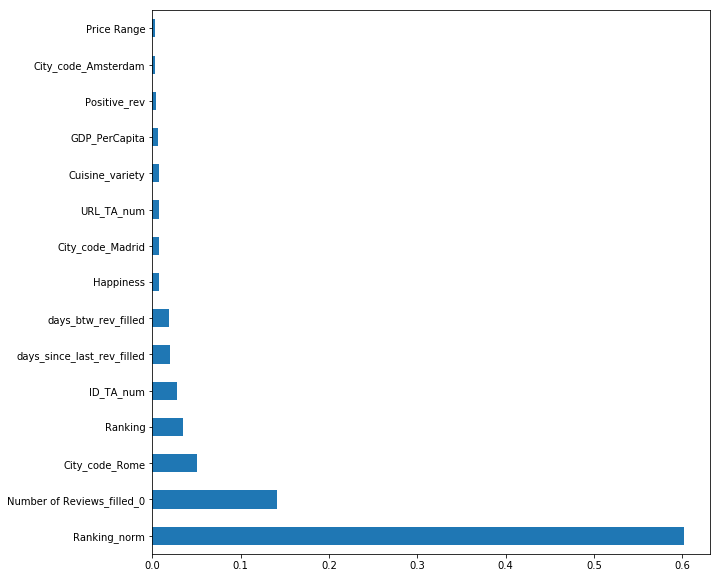

In [315]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

(15.5, -0.5)

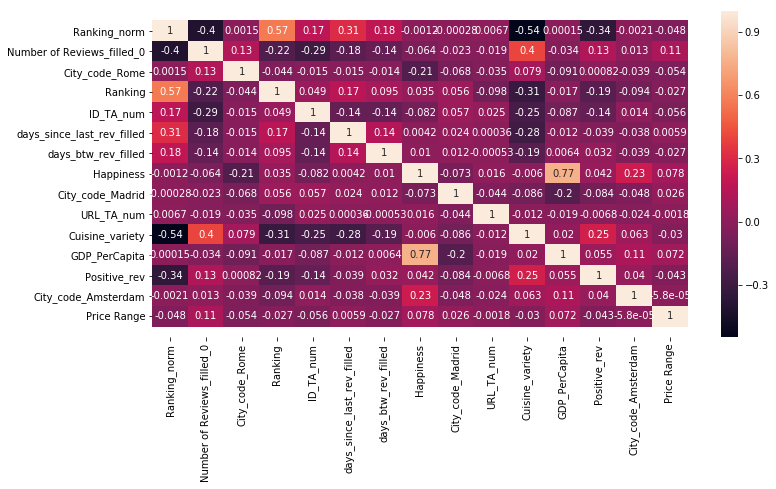

In [316]:
df_temp = df_preproc.loc[data['sample'] == 1, list(feat_importances.nlargest(15).index[0:15])]
plt.rcParams['figure.figsize'] = (12,6)
ax = sns.heatmap(df_temp.corr(), annot=True, fmt='.2g')
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

# Submission
Если все устраевает - готовим Submission на кагл

In [317]:
test_data.sample(10)

,Ranking,Price Range,Rating,Number of Reviews_filled_0,City_code_Amsterdam,City_code_Athens,City_code_Barcelona,City_code_Berlin,City_code_Bratislava,City_code_Brussels,...,Cuisine_Austrian,Cuisine_nan,Cuisine_variety,Ranking_norm,no_price_data,days_btw_rev_filled,days_since_last_rev_filled,Positive_rev,ID_TA_num,URL_TA_num
3830,2263.0,2,0.0,4.0,0,0,0,0,0,0,...,0,1,0,0.748390,0,122.0,640.0,4,10370438,187331
4820,8847.0,2,0.0,4.0,0,0,0,0,0,0,...,0,1,0,0.312450,0,86.0,220.0,4,11961398,187147
5293,448.0,2,0.0,223.0,0,0,0,0,0,0,...,0,0,4,-0.586752,0,9.0,93.0,4,698136,186525
6669,2067.0,2,0.0,20.0,0,0,1,0,0,0,...,0,1,0,-0.533851,0,644.0,235.0,4,8683959,187497
8824,2367.0,2,0.0,260.0,0,0,0,0,0,0,...,0,0,6,-0.806716,0,38.0,143.0,4,1389745,186338
2162,5428.0,2,0.0,7.0,0,0,0,1,0,0,...,0,1,0,0.803173,0,45.0,327.0,4,8411341,187323
29,550.0,2,0.0,465.0,0,0,0,0,0,0,...,0,0,6,-0.005266,0,258.0,107.0,4,1495732,190479
6072,1368.0,2,0.0,3.0,0,0,0,0,0,0,...,0,0,1,-0.002007,0,88.0,176.0,3,11876327,187309
23,1255.0,2,0.0,51.0,0,0,0,0,0,1,...,0,0,3,-0.218342,0,127.0,140.0,4,7653791,1136495
5068,299.0,2,0.0,39.0,0,0,0,0,0,0,...,0,0,7,-0.723037,0,70.0,77.0,4,7052762,188113


In [318]:
test_data = test_data.drop(['Rating'], axis=1)

In [319]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [320]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [321]:
predict_submission

array([3.02 , 4.17 , 4.13 , ..., 3.025, 4.43 , 4.25 ])

In [322]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.020
1,id_1,4.170
2,id_2,4.130
3,id_3,4.370
4,id_4,4.465
5,id_5,4.390
6,id_6,1.975
7,id_7,2.405
8,id_8,4.020
9,id_9,4.595
